In [2]:
import os
import pandas as pd
import csv
import numpy as np
import time

from datetime import datetime

predicted_data_path = "/home/aayush/accelerometer/accprocess/results"
annotated_data_path = "/home/yacine/accel/capture24/participants/"

labels_dict_location = "/home/aayush/accelerometer/accprocess/anno-label.csv"

In [3]:
def get_files(data_path, predicted_files=False, annotated_files=False) -> None:
    total_csv_zipped = []
    for path, dirnames, filenames in os.walk(data_path):

        for file in filenames:
            if file.endswith(".csv.gz") and predicted_files:
                # paths contains the base directory for that file.
                # dirnames contains other directories within this folder.
                # filenames contains the list of filenames within path.
                total_csv_zipped.append(os.path.join(path, file))
                
            if file.endswith(".csv") and annotated_files and file[0]!='c': #ignore the capture24 file
                # paths contains the base directory for that file.
                # dirnames contains other directories within this folder.
                # filenames contains the list of filenames within path.
                total_csv_zipped.append(os.path.join(path, file))

    return sorted(total_csv_zipped)

In [4]:
def create_labels_dict():
    labels_dict = {}
    with open(labels_dict_location, "r") as annotation_dict:
        reader = csv.DictReader(annotation_dict)
        for row in reader:
            if labels_dict.get(row['annotation']) is None:
                labels_dict[row['annotation']] = [row['label:Walmsley2020']]
            else:
                labels_dict[row['annotation']].append(row['label:Walmsley2020'])
    return labels_dict


def parse_datetime(dt_string):
    clean_datetime_str = dt_string.split('[')[0].strip()
    dt_object = pd.to_datetime(clean_datetime_str)
    return dt_object


def parse_datetime_df_time(dt_string):
    clean_datetime_str = dt_string.split('[')[0].strip()
    clean_datetime_str = clean_datetime_str.split('+')[0].strip()
    dt_object = pd.to_datetime(clean_datetime_str)
    return dt_object

In [5]:
predicted_data_files = get_files(data_path=predicted_data_path, predicted_files=True)
annotated_data_files = get_files(data_path=annotated_data_path, annotated_files=True)

assert len(predicted_data_files) == len(annotated_data_files), "Number of predicted and annotated data files should be the same."
labels_dict = create_labels_dict()
labels = ["light", "moderate-vigorous", "sedentary", "sleep"]

In [7]:
def decode_activities(data_file):
    df = pd.read_csv(data_file)
    
    # retrieve only the activities headers
    activities = df[df.columns.values.tolist()[2:6]]
    
    # whichever activity is depicted by 1, use it as the predicted activity
    df["activity_predicted_walmsley"] = activities[activities==1].idxmax(axis=1)    
    return df
    
    
def process_annotated_data(annotated_data_file):
    annotated_data = pd.read_csv(annotated_data_file)
    # Take the timestamp after every thirty seconds
    actual_labels = annotated_data[["annotation", "time"]][0::3000]
    
    # Convert to datetime object
    actual_time = actual_labels["time"].apply(parse_datetime)
    actual_labels["time"] = actual_time
    
    return actual_labels
    


def filtering_data(df, actual_labels, labels_dict, predicted_id):
    
    # Convert to datetime object
    df['time_cleaned'] = df['time'].apply(parse_datetime_df_time)
    df["participant_id"] = predicted_id
    
    # # drop all 'nan' rows from actual labels
    # actual_labels = actual_labels.dropna(subset=['annotation'])
    
    # replace the annotated labels with the same format of strings as predicted labels using mapping from labels_dict
    flat_dict = {k: v[0] for k, v in labels_dict.items()}
    actual_labels['annotation'].replace(flat_dict, inplace=True)
    
    
    return actual_labels, df

In [8]:
df_final_all = []

for predicted_file, annotated_file in zip(sorted(predicted_data_files), sorted(annotated_data_files)):
    predicted_id = int(predicted_file.split("/")[-1].split("-")[0][1:])
    annotated_id = int(annotated_file.split("/")[-1].split(".")[0][1:])
    assert predicted_id == annotated_id, "Participant ID for annotated and predicted should be same"

    df = decode_activities(predicted_file)
    actual_labels = process_annotated_data(annotated_file)

    actual_labels, df = filtering_data(df, actual_labels, labels_dict, predicted_id)
    
    df["time"] = df["time_cleaned"]
    
    final = df
    final = final.drop(columns=["time_cleaned"])
    
    
    # final.to_csv(os.path.join("/home/aayush/accelerometer/accprocess/data_saved/gender", f"{predicted_id}.csv"), index=False)
    df_final_all.append(final)
    
    print("##############DONE#############")

1
/home/aayush/accelerometer/accprocess/results/P001-timeSeries.csv.gz
/home/yacine/accel/capture24/participants/P001.csv
/home/aayush/accelerometer/accprocess/data_saved/PA3/combined/1.csv


/tmp/ipykernel_3245228/3851051775.py:17: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


##############DONE#############
2
/home/aayush/accelerometer/accprocess/results/P002-timeSeries.csv.gz
/home/yacine/accel/capture24/participants/P002.csv
/home/aayush/accelerometer/accprocess/data_saved/PA3/combined/2.csv


KeyboardInterrupt: 

In [86]:
df_final_all_pd = pd.concat(df_final_all, ignore_index=True, axis=0)


In [88]:
df_final_all_pd

,time,acc,light,moderate-vigorous,sedentary,sleep,CpSB,CpLPA,CpMPA,CpVPA,...,MET,activity_predicted_walmsley,activity_predicted_cp,participant_id,annotation_x,axis1,axis2,axis3,annotation_y,PA3
0,2016-11-13 02:18:00,0.767,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.95,sleep,sedentary,1,sleep,22.0,27.0,31.0,sleep,sedentary
1,2016-11-13 02:18:30,0.819,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.95,sleep,sedentary,1,sleep,0.0,0.0,0.0,sleep,sedentary
2,2016-11-13 02:19:00,1.226,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.95,sleep,sedentary,1,sleep,0.0,0.0,0.0,sleep,sedentary
3,2016-11-13 02:19:30,1.292,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.95,sleep,sedentary,1,sleep,0.0,0.0,0.0,sleep,sedentary
4,2016-11-13 02:20:00,1.213,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.95,sleep,sedentary,1,sleep,0.0,0.0,0.0,sleep,sedentary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452011,2016-06-12 06:16:30,18.796,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.95,sleep,sedentary,151,sleep,0.0,0.0,0.0,sleep,sedentary
452012,2016-06-12 06:17:00,4.435,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.95,sleep,sedentary,151,sleep,0.0,0.0,0.0,sleep,sedentary
452013,2016-06-12 06:17:30,4.513,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.95,sleep,sedentary,151,sleep,0.0,0.0,0.0,sleep,sedentary
452014,2016-06-12 06:18:00,4.288,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.95,sleep,sedentary,151,sleep,0.0,0.0,0.0,sleep,sedentary


In [32]:
# df_final_all_pd.to_csv("/home/aayush/accelerometer/accprocess/data_saved/PA123.csv", index=False)
df_final_all_pd = pd.read_csv("/home/aayush/accelerometer/accprocess/data_saved/PA123.csv")

In [33]:
gender = pd.read_csv("/home/aayush/accelerometer/accprocess/data_saved/gender_data_capture24.csv")

In [34]:
def extract_pid(pid):
    return int(str(pid)[1:])

gender["pid"] = gender["pid"].apply(extract_pid)

In [35]:
female_pid = gender[gender["sex"]=="F"]["pid"]
male_pid = gender[gender["sex"]=="M"]["pid"]

female_rows = df_final_all_pd[df_final_all_pd["participant_id"].isin(female_pid)]
male_rows = df_final_all_pd[df_final_all_pd["participant_id"].isin(male_pid)]
print(len(male_rows))
print(len(female_rows))

155824
296192


In [41]:
print(f"Number of female participants: {len(female_pid)}")
print(f"Number of male participants: {len(male_pid)}")

Number of female participants: 99
Number of male participants: 52


In [36]:
print(df_final_all_pd[df_final_all_pd["time"].isna()])
print(df_final_all_pd[df_final_all_pd["participant_id"].isna()])

Empty DataFrame
Columns: [time, acc, light, moderate-vigorous, sedentary, sleep, CpSB, CpLPA, CpMPA, CpVPA, CpMVPA, MET, activity_predicted_walmsley, activity_predicted_cp, participant_id, annotation_x, axis1, axis2, axis3, annotation_y, PA3]
Index: []

[0 rows x 21 columns]
Empty DataFrame
Columns: [time, acc, light, moderate-vigorous, sedentary, sleep, CpSB, CpLPA, CpMPA, CpVPA, CpMVPA, MET, activity_predicted_walmsley, activity_predicted_cp, participant_id, annotation_x, axis1, axis2, axis3, annotation_y, PA3]
Index: []

[0 rows x 21 columns]


In [37]:
# female graphs
df = female_rows[["activity_predicted_walmsley", "participant_id", "annotation_x", "time"]]
df = df.dropna()
print(df)

annotation_proportions = df.groupby("participant_id", group_keys=True)["annotation_x"].value_counts(normalize=True).unstack()
walmsley_proportions = df.groupby("participant_id", group_keys=True)["activity_predicted_walmsley"].value_counts(normalize=True).unstack()

all_columns = sorted(set(walmsley_proportions.columns) | set(annotation_proportions.columns))
walmsley_proportions = walmsley_proportions.reindex(columns=all_columns, fill_value=0)
walmsley_proportions = walmsley_proportions * 24

annotation_proportions = annotation_proportions.reindex(columns=all_columns, fill_value=0)
annotation_proportions = annotation_proportions * 24


# Compare the predicted values with the true labels
correct_predictions = df["activity_predicted_walmsley"] == df["annotation_x"]

# Calculate accuracy as the mean of correct predictions
accuracy = correct_predictions.mean()

print(f"Female Accuracy: {accuracy}")


       activity_predicted_walmsley  participant_id annotation_x  \
0                            sleep               1        sleep   
1                            sleep               1        sleep   
2                            sleep               1        sleep   
3                            sleep               1        sleep   
4                            sleep               1        sleep   
...                            ...             ...          ...   
452011                       sleep             151        sleep   
452012                       sleep             151        sleep   
452013                       sleep             151        sleep   
452014                       sleep             151        sleep   
452015                       sleep             151        sleep   

                       time  
0       2016-11-13 02:18:00  
1       2016-11-13 02:18:30  
2       2016-11-13 02:19:00  
3       2016-11-13 02:19:30  
4       2016-11-13 02:20:00  
...            

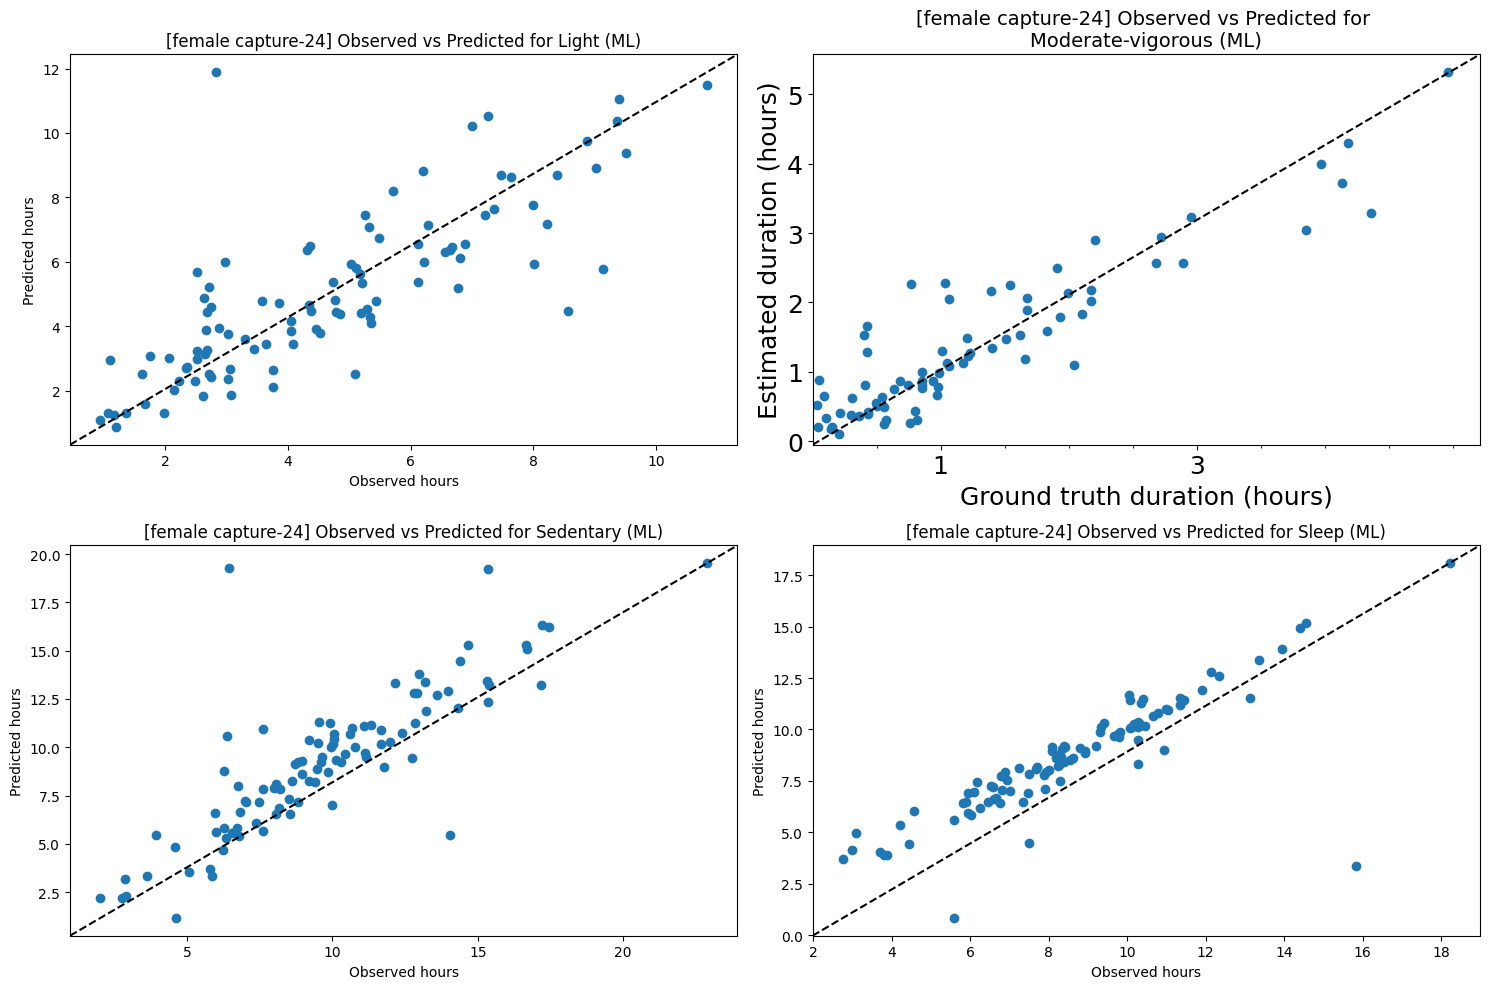

In [38]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


# Scatter plots for each classification
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
classifications = ["light", "moderate-vigorous", "sedentary", "sleep"]
for i, classification in enumerate(classifications):
    ax = axs[i//2, i%2]
    
    observed = annotation_proportions[classification]
    predicted = walmsley_proportions[classification]
        
    ax.scatter(observed, predicted)

    if classification=="moderate-vigorous":
        fsize=18
        ax.set_title(f'[female capture-24] Observed vs Predicted for \n{classification.capitalize()} (ML)', fontsize=14)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed', color='black')  # Diagonal line for reference
        ax.set_xlabel('Ground truth duration (hours)', fontsize=fsize)
        ax.set_ylabel('Estimated duration (hours)', fontsize=fsize)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.set_xlim(xmin=0)
        ax.set_ylim(ymin=-0.05)  # so that markers are not cut by half at the bottom axis.
        ax.set_xticks(np.arange(1, max(observed), 2.0))
        ax.set_yticks(np.arange(0, max(predicted), 1.0))
        ax.tick_params(axis='both', which='major', labelsize=fsize)

    else:
        ax.set_title(f'[female capture-24] Observed vs Predicted for {classification.capitalize()} (ML)')    
        ax.set_xlabel('Observed hours')
        ax.set_ylabel('Predicted hours')
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed', color='black')  # Diagonal line for reference

plt.tight_layout()
plt.show()


In [39]:
# male graphs
df = male_rows[["activity_predicted_walmsley", "activity_predicted_cp", "participant_id", "annotation_x", "PA3", "time"]]
df = df.dropna()
print(df)

annotation_proportions = df.groupby("participant_id", group_keys=True)["annotation_x"].value_counts(normalize=True).unstack()
walmsley_proportions = df.groupby("participant_id", group_keys=True)["activity_predicted_walmsley"].value_counts(normalize=True).unstack()

all_columns = sorted(set(walmsley_proportions.columns) | set(annotation_proportions.columns))
walmsley_proportions = walmsley_proportions.reindex(columns=all_columns, fill_value=0)
walmsley_proportions = walmsley_proportions * 24

annotation_proportions = annotation_proportions.reindex(columns=all_columns, fill_value=0)
annotation_proportions = annotation_proportions * 24

# Compare the predicted values with the true labels
correct_predictions = df["activity_predicted_walmsley"] == df["annotation_x"]

# Calculate accuracy as the mean of correct predictions
accuracy = correct_predictions.mean()

print(f"Male Accuracy: {accuracy}")


       activity_predicted_walmsley activity_predicted_cp  participant_id  \
19107                        sleep             sedentary               7   
19108                        sleep             sedentary               7   
19109                        sleep             sedentary               7   
19110                        sleep             sedentary               7   
19111                        sleep             sedentary               7   
...                            ...                   ...             ...   
429961                       sleep             sedentary             144   
429962                       sleep             sedentary             144   
429963                       sleep             sedentary             144   
429964                       sleep             sedentary             144   
429965                       sleep             sedentary             144   

       annotation_x        PA3                 time  
19107         sleep  sedentary  2

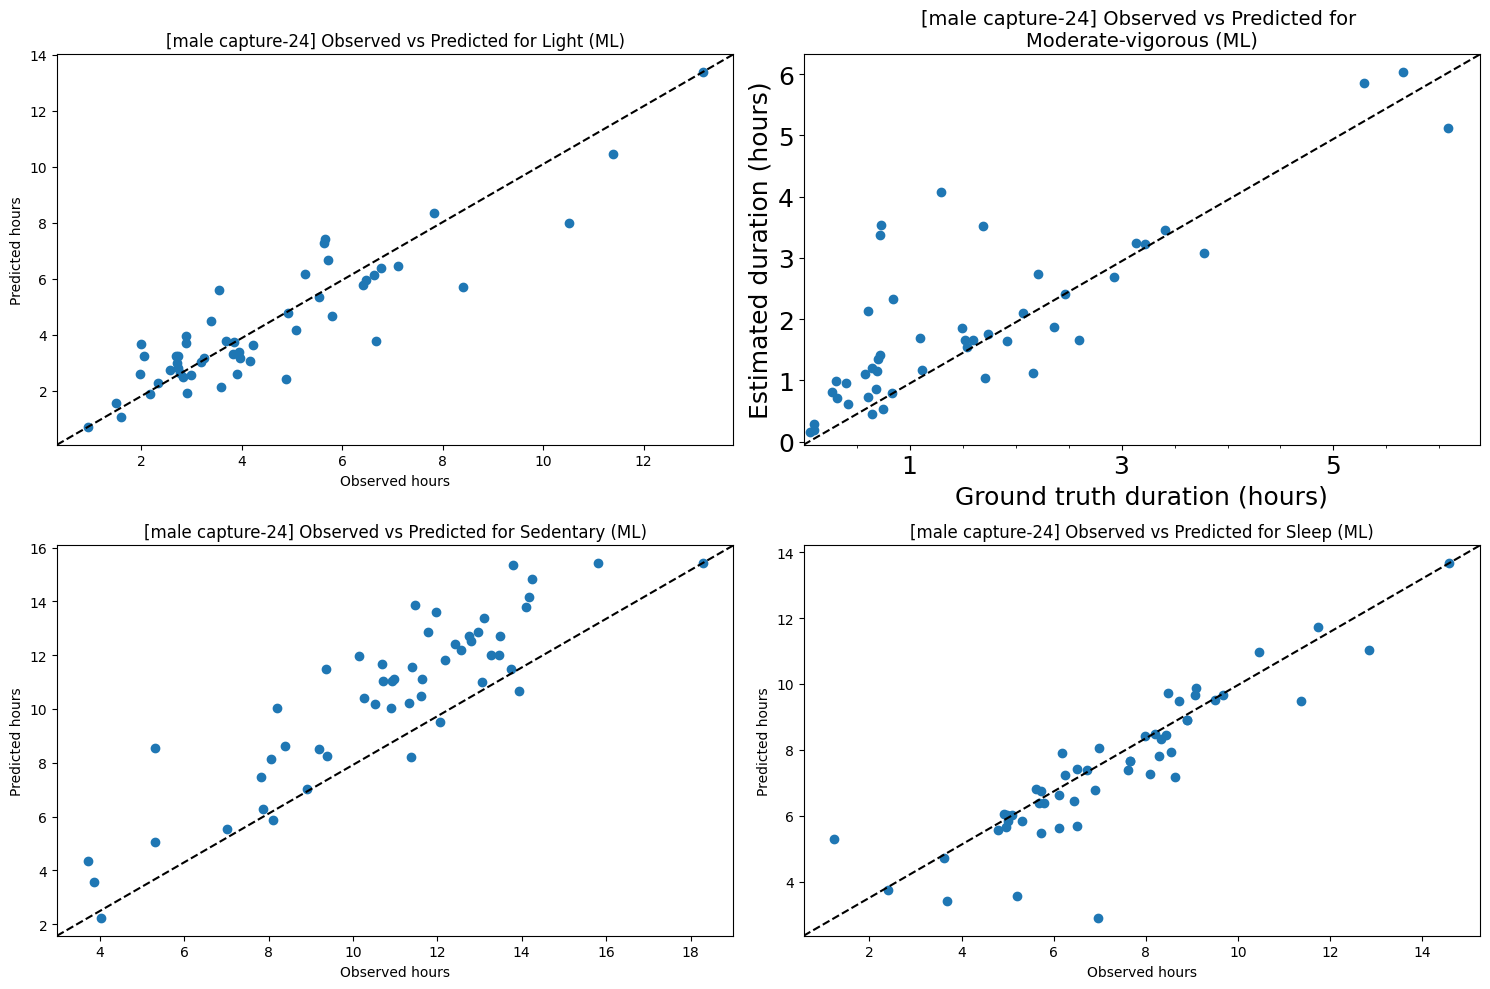

In [40]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


# Scatter plots for each classification
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
classifications = ["light", "moderate-vigorous", "sedentary", "sleep"]
for i, classification in enumerate(classifications):
    ax = axs[i//2, i%2]
    
    observed = annotation_proportions[classification]
    predicted = walmsley_proportions[classification]
        
    ax.scatter(observed, predicted)

    if classification=="moderate-vigorous":
        fsize=18
        ax.set_title(f'[male capture-24] Observed vs Predicted for \n{classification.capitalize()} (ML)', fontsize=14)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed', color='black')  # Diagonal line for reference
        ax.set_xlabel('Ground truth duration (hours)', fontsize=fsize)
        ax.set_ylabel('Estimated duration (hours)', fontsize=fsize)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.set_xlim(xmin=0)
        ax.set_ylim(ymin=-0.05)  # so that markers are not cut by half at the bottom axis.
        ax.set_xticks(np.arange(1, max(observed), 2.0))
        ax.set_yticks(np.arange(0, max(predicted), 1.0))
        ax.tick_params(axis='both', which='major', labelsize=fsize)

    else:
        ax.set_title(f'[male capture-24] Observed vs Predicted for {classification.capitalize()} (ML)')    
        ax.set_xlabel('Observed hours')
        ax.set_ylabel('Predicted hours')
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed', color='black')  # Diagonal line for reference

plt.tight_layout()
plt.show()


okay, (considering we dropped NaN rows for actual label and walmsley prediction)



for female rows where the walmsley prediction matches the actual label:

Female Accuracy: 0.7591922142631468

plot: above




for male rows where the walmsley prediction matches the actual label:

Male Accuracy: 0.7086338491702262

plot: above


